In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import mpu
import statistics
sns.set()

In [61]:
static_file = 'pred8.csv'
static = pd.read_csv(static_file)

pop_file = 'pop2021_by_housing_clean.csv'
pop = pd.read_csv(pop_file)

In [62]:
static['adj_stations'] = np.nan
static['dist_to_nearest_station'] = np.nan
cutoff = 2
for cur_row in range(len(static)):
    cur = (static.loc[cur_row, 'lat'], static.loc[cur_row, 'long'])
    s_count = 0
    all_dist = []
    for adj_row in range(len(static)):
        if cur_row == adj_row:
            continue
        if (static.loc[cur_row, 'status'] == 'operational') & (static.loc[adj_row, 'status'] == 'future'):
            continue
        adj = (static.loc[adj_row, 'lat'], static.loc[adj_row, 'long'])
        dist = mpu.haversine_distance(cur, adj)
        all_dist.append(dist)
        if dist < cutoff:
            s_count += 1
    static.loc[cur_row, 'adj_stations'] = s_count
    static.loc[cur_row, 'dist_to_nearest_station'] = min(all_dist)

In [63]:
static[static.adj_stations==0]

,name,station_code,code,code2,code3,interchange,NS,SW,CC,EW,...,bus_interchange,mrt_interchange,svc,bus count,pop,geometry,groceryCount,mallCount,adj_stations,dist_to_nearest_station
26,Changi Airport,CG2,CG2,NaN,NaN,False,NaN,NaN,NaN,NaN,...,True,False,"53A,858,24,858B,27,53,110,34B,34,36",10,10.0,POINT (1.357478974 103.98788359999999),2,1,0.0,3.417984
70,Joo Koon,EW29,EW29,NaN,NaN,False,NaN,NaN,NaN,29.0,...,True,False,"99,254,257,255,193,252,974A,182,192,253,974,25...",13,30.0,POINT (1.3277170409999999 103.678375),7,1,0.0,2.185355
122,Springleaf,TE4,TE4,NaN,NaN,False,NaN,NaN,NaN,NaN,...,False,False,"138A,167,138,169,860,860T,980",7,890.0,POINT (1.397581061 103.8178569),0,0,0.0,2.399198


[Text(0.5, 1.0, 'Distribution of number of adj stations')]

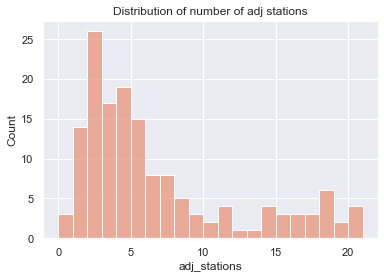

In [88]:
sns.histplot(data=static.adj_stations, binwidth=1, color='darksalmon').set(title='Distribution of number of adj stations')

[Text(0.5, 1.0, 'Distribution of distance to nearest station')]

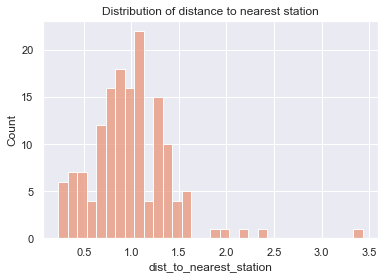

In [89]:
sns.histplot(data=static.dist_to_nearest_station, 
             binwidth=0.1, color='darksalmon').set(title='Distribution of distance to nearest station')

In [66]:
hubs = ['Jurong East', 'Tampines', 'Woodlands', 'Raffles Place']
static['hub'] = np.isin(static.name, hubs)
hub_dict = {}
for hub in hubs:
    latitude = static[static.name==hub]['lat'].values[0]
    longitutde = static[static.name==hub]['long'].values[0]
    hub_dict[hub] = [latitude, longitutde]

static['min_dist_to_hub'] = np.nan
static['nearest_hub'] = np.nan
for row in range(len(static)):
    src = (static.loc[row, 'lat'], static.loc[row, 'long'])
    dist = []
    for hub in hub_dict:
        dest = hub_dict[hub]
        dist.append(mpu.haversine_distance(src, dest))
    min_dist = min(dist)
    index = dist.index(min_dist)
    nearest_hub = list(hub_dict.keys())[index]
    static.loc[row, 'min_dist_to_hub'] = min_dist
    static.loc[row, 'nearest_hub'] = nearest_hub

In [67]:
def add_ranks(op, col_names, col_source):
    # col_names : new rank col names
    # col source : cols to be ranked
    op = op.drop(columns=[x for x in col_names if x in op.columns]) # removing existing columns to avoid duplicates

    new_ranks = []
    for i, col in enumerate(col_source):
        rank_col = op[col].rank(pct=True)
        rank_col.name = col_names[i]
        new_ranks.append(rank_col)
    
    new_ranks.insert(0, op)
    op_ranked = pd.concat(new_ranks, axis=1)
    return op_ranked

In [68]:
static.isna().sum()

name                         0
station_code                 0
code                         0
code2                      123
code3                      150
interchange                 24
NS                         124
SW                         151
CC                         119
EW                         118
NE                         134
BP                         149
CE                         149
DT                         115
PW                         150
TE                         124
PE                         150
CG                         149
SE                         150
totalTapIn                  24
totalTapOut                 24
cluster                     24
postal                       0
x                            0
y                            0
lat                          0
long                         0
subzone                      0
area                         0
region                       0
status                       0
bus_interchange              0
mrt_inte

[Text(0.5, 1.0, 'Distribution of mall count (per station)')]

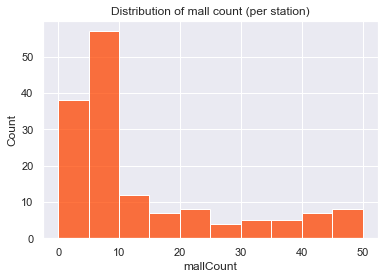

In [98]:
sns.histplot(data=static['mallCount'], 
             binwidth=5, 
             color='orangered').set(title='Distribution of mall count (per station)')

In [118]:
static2 = static.dropna(subset=['bus count', 'pop']) # trimming out NA observations
col_names = ['bus_rank', 'pop_rank', 'hub_dist_rank', 'adj_count_rank', 'dist_to_neighbour_rank', 'tapin_rank', 'tapout_rank']
col_source = ['bus count', 'pop', 'min_dist_to_hub', 'adj_stations', 'dist_to_nearest_station', 'totalTapIn', 'totalTapOut']
static_ranked = add_ranks(static2, col_names, col_source)
static_ranked['pop-bus_rank'] = static_ranked.pop_rank.sub(static_ranked.bus_rank)
static_ranked_post_drop = static_ranked.shape
dropped = static.shape[0] - static_ranked_post_drop[0]
print(f'df after trimming NA rows: {static_ranked_post_drop}')
print(f'number of NA rows dropped: {dropped}')
print(f'% data loss: {round(dropped/static_ranked_post_drop[0] * 100,2)}')

df after trimming NA rows: (149, 52)
number of NA rows dropped: 2
% data loss: 1.34


In [119]:
static.dtypes

name                        object
station_code                object
code                        object
code2                       object
code3                       object
interchange                 object
NS                         float64
SW                         float64
CC                         float64
EW                         float64
NE                         float64
BP                         float64
CE                         float64
DT                         float64
PW                         float64
TE                         float64
PE                         float64
CG                         float64
SE                         float64
totalTapIn                 float64
totalTapOut                float64
cluster                    float64
postal                       int64
x                          float64
y                          float64
lat                        float64
long                       float64
subzone                     object
area                

In [120]:
static.head()

,name,station_code,code,code2,code3,interchange,NS,SW,CC,EW,...,bus count,pop,geometry,groceryCount,mallCount,adj_stations,dist_to_nearest_station,hub,min_dist_to_hub,nearest_hub
0,Bukit Panjang,BP6/DT1,BP6,DT1,NaN,True,NaN,NaN,NaN,NaN,...,36,9930.0,POINT (1.379002116 103.76153509999999),23,14,2.0,1.071309,False,5.529046,Jurong East
1,MacPherson,CC10/DT26,CC10,DT26,NaN,True,NaN,NaN,10.0,NaN,...,21,28360.0,POINT (1.326150245 103.88929859999999),37,3,7.0,0.677504,False,6.287145,Raffles Place
2,Tai Seng,CC11,CC11,NaN,NaN,False,NaN,NaN,11.0,NaN,...,20,13830.0,POINT (1.3351415009999998 103.88838929999999),32,6,4.0,1.004879,False,6.624440,Tampines
3,Bartley,CC12,CC12,NaN,NaN,False,NaN,NaN,12.0,NaN,...,4,0.0,POINT (1.342501178 103.8801779),20,5,5.0,1.103678,False,7.233564,Raffles Place
4,Lorong Chuan,CC14,CC14,NaN,NaN,False,NaN,NaN,14.0,NaN,...,2,8490.0,POINT (1.351612171 103.86415190000001),28,9,3.0,0.964370,False,7.635612,Raffles Place


In [70]:
# static_ranked.to_csv('static_ranked.csv', index=False)

In [124]:
op = static_ranked[static_ranked.status=='operational']
future = static_ranked[static_ranked.status=='future']
plt_target_cols = col_names + ['pop-bus_rank'] + col_source

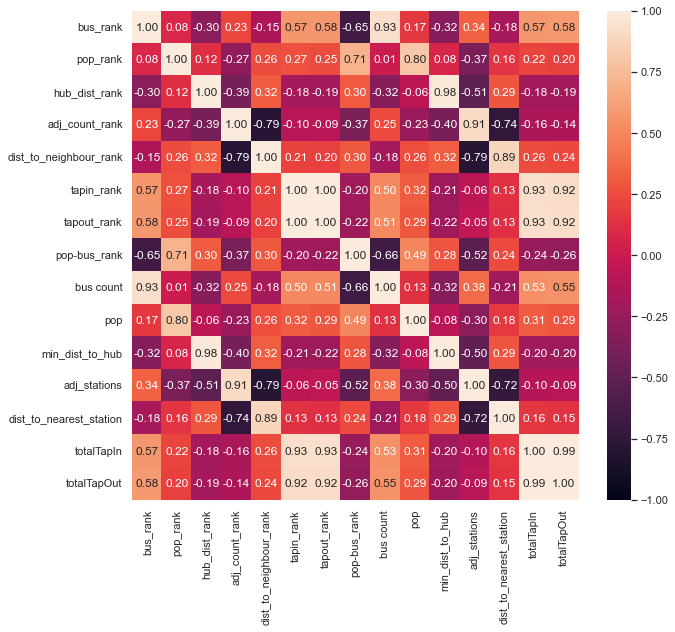

In [125]:
f = plt.figure(figsize=(10,9))
sns.heatmap(op[plt_target_cols].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

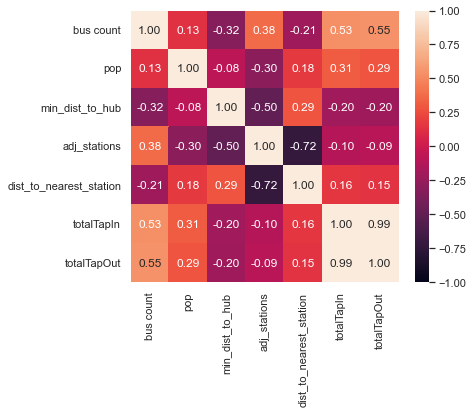

In [126]:
f = plt.figure(figsize=(6,5))
sns.heatmap(op[col_source].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

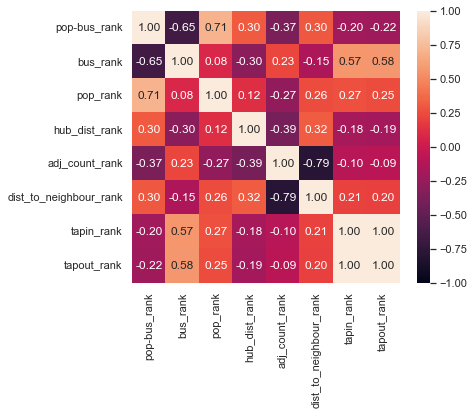

In [128]:
f = plt.figure(figsize=(6,5))
temp_cols = ['pop-bus_rank']+col_names
sns.heatmap(op[temp_cols].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [75]:
len(plt_target_cols)

11

In [80]:
0%2

0

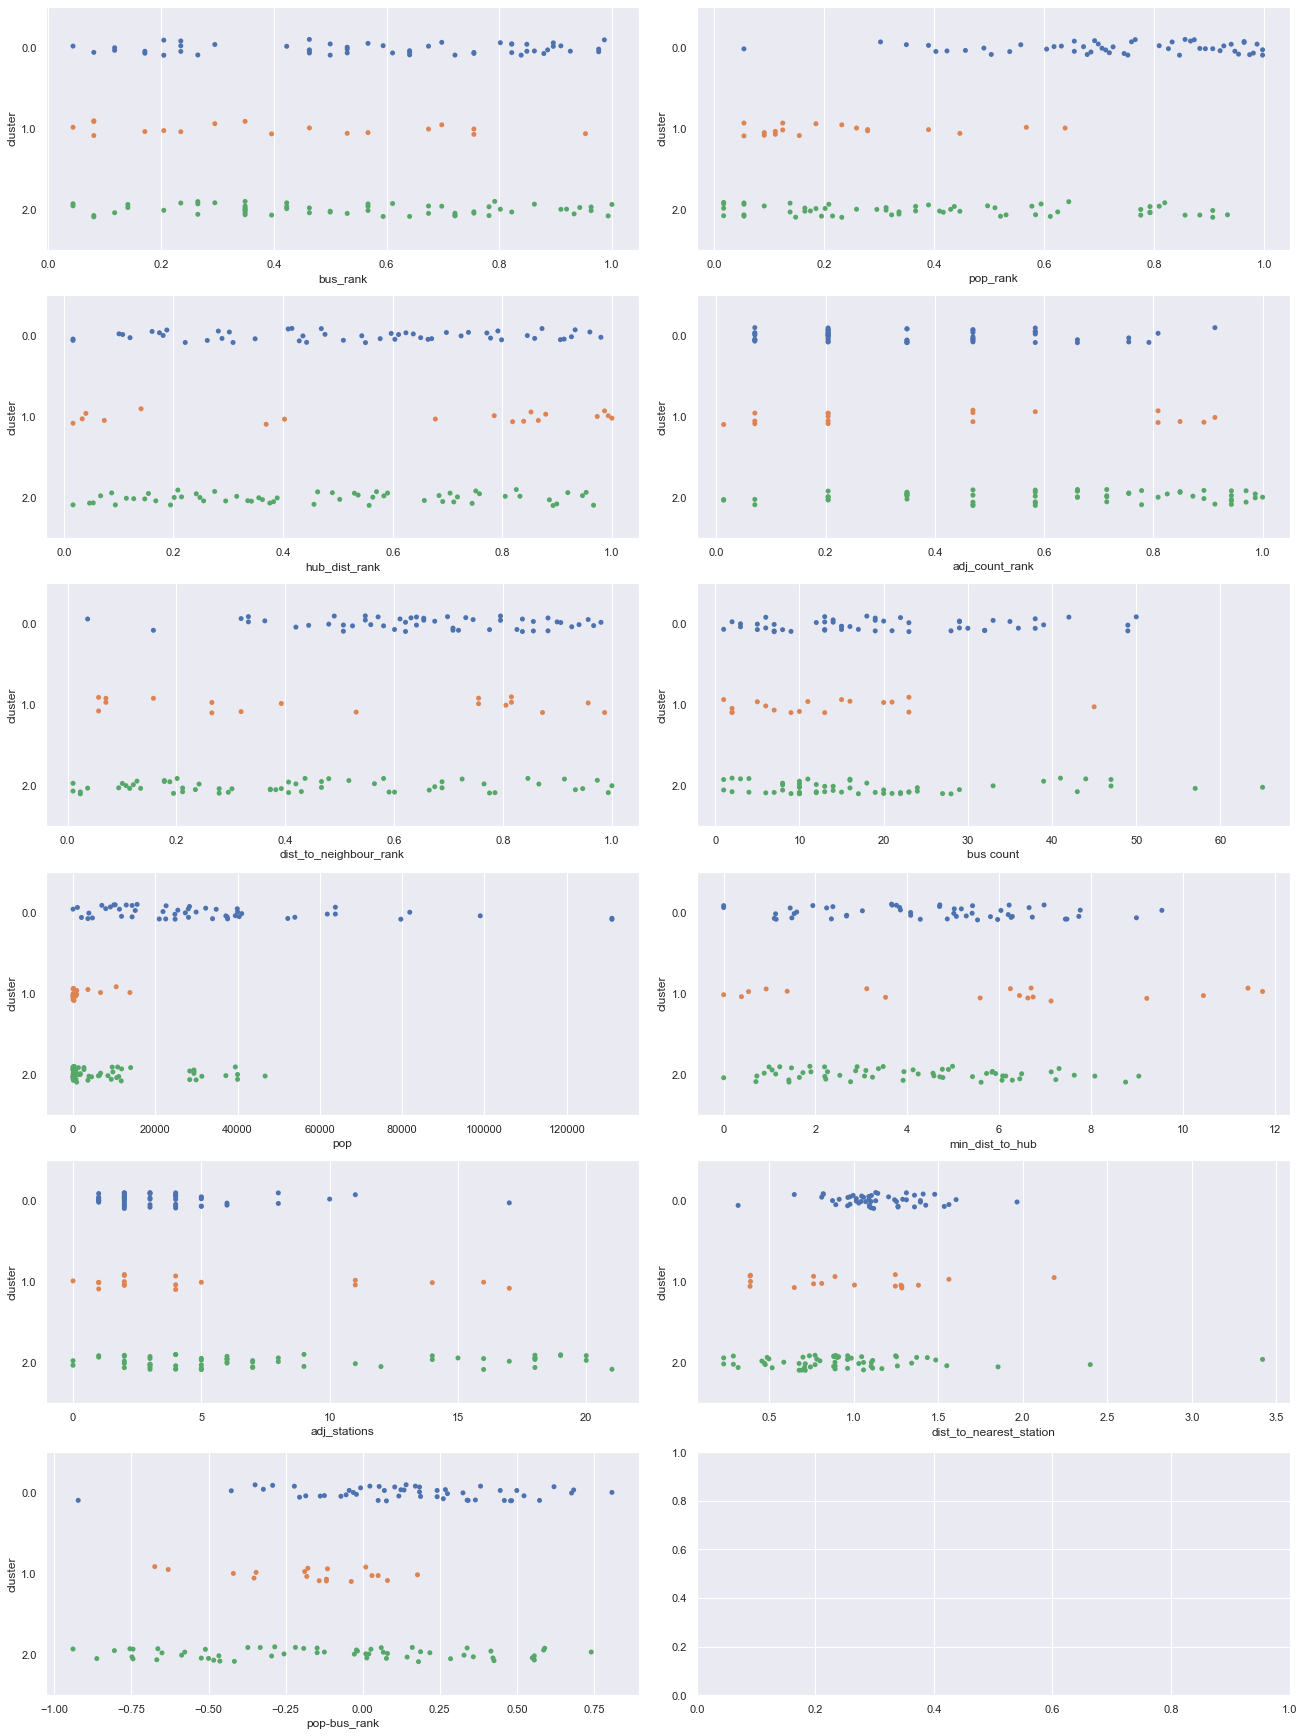

In [85]:
f, axes = plt.subplots((len(plt_target_cols)+1)//2, 2, figsize=(18, 24), constrained_layout=True)

count = 0
for var in plt_target_cols:
    sns.stripplot(x = var, y = "cluster", data = op, orient = "h", ax = axes[count//2, count%2])
    count += 1

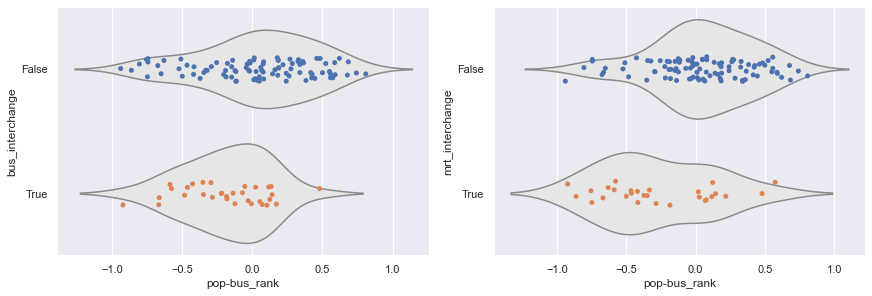

In [82]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sns.stripplot(x = 'pop-bus_rank', y = "bus_interchange", data = op, orient = "h", ax = axes[0])
sns.stripplot(x = 'pop-bus_rank', y = "mrt_interchange", data = op, orient = "h", ax = axes[1])
sns.violinplot(x = 'pop-bus_rank', y = "bus_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[0])
sns.violinplot(x = 'pop-bus_rank', y = "mrt_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[1])

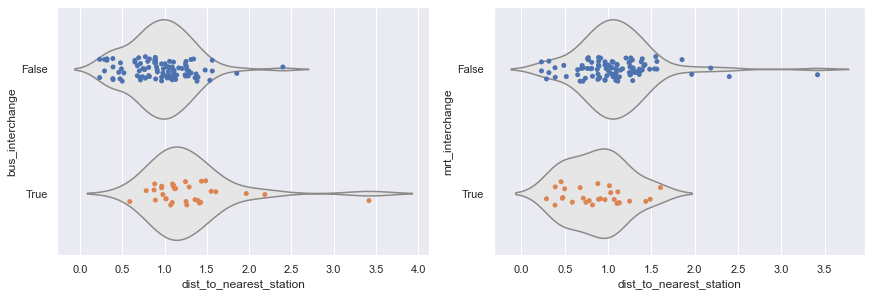

In [103]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sns.stripplot(x = 'dist_to_nearest_station', y = "bus_interchange", data = op, orient = "h", ax = axes[0])
sns.stripplot(x = 'dist_to_nearest_station', y = "mrt_interchange", data = op, orient = "h", ax = axes[1])
sns.violinplot(x = 'dist_to_nearest_station', y = "bus_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[0])
sns.violinplot(x = 'dist_to_nearest_station', y = "mrt_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[1])

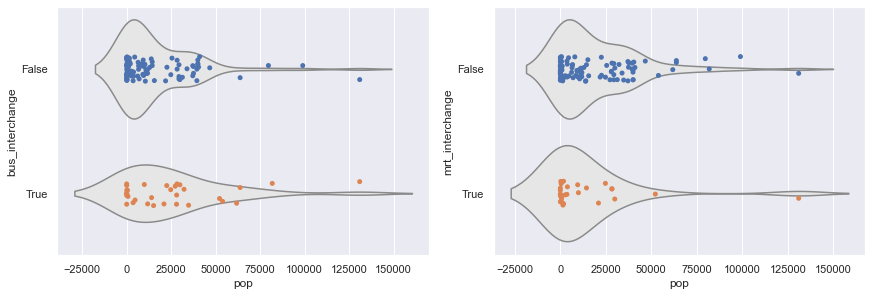

In [102]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sns.stripplot(x = 'pop', y = "bus_interchange", data = op, orient = "h", ax = axes[0])
sns.stripplot(x = 'pop', y = "mrt_interchange", data = op, orient = "h", ax = axes[1])
sns.violinplot(x = 'pop', y = "bus_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[0])
sns.violinplot(x = 'pop', y = "mrt_interchange", data = op, orient = "h", inner=None, color=".9", ax = axes[1])

In [106]:
lines = ['CC', 'NE', 'NS', 'DT', 'EW', 'CG', 'BP', 'TE', 'CE']
line_df = {}
means = []
for line in lines[:5]:
    line_df[line] = op[op[line].isna()==False].sort_values(by=line).reset_index(drop=True)
    line_df[line]['dist_spacing'] = np.nan
    for row in range(1, len(line_df[line])):
        cur = (line_df[line].loc[row, 'lat'], line_df[line].loc[row, 'long'])
        prev = (line_df[line].loc[row-1, 'lat'], line_df[line].loc[row-1, 'long'])
        line_df[line].loc[row, 'dist_spacing'] = mpu.haversine_distance(cur, prev)
    avg = line_df[line].dist_spacing.mean()
    means.append(avg)
    print(line, avg)
print('avg', statistics.mean(means))

CC 1.1217902067514043
NE 1.2525022193981807
NS 1.5945657802387136
DT 1.1214005210547937
EW 1.4585595168754866
avg 1.3097636488637159


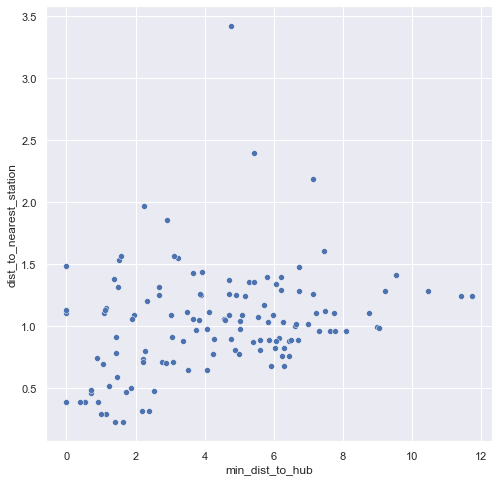

In [110]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(x='min_dist_to_hub', y='dist_to_nearest_station', data=op)

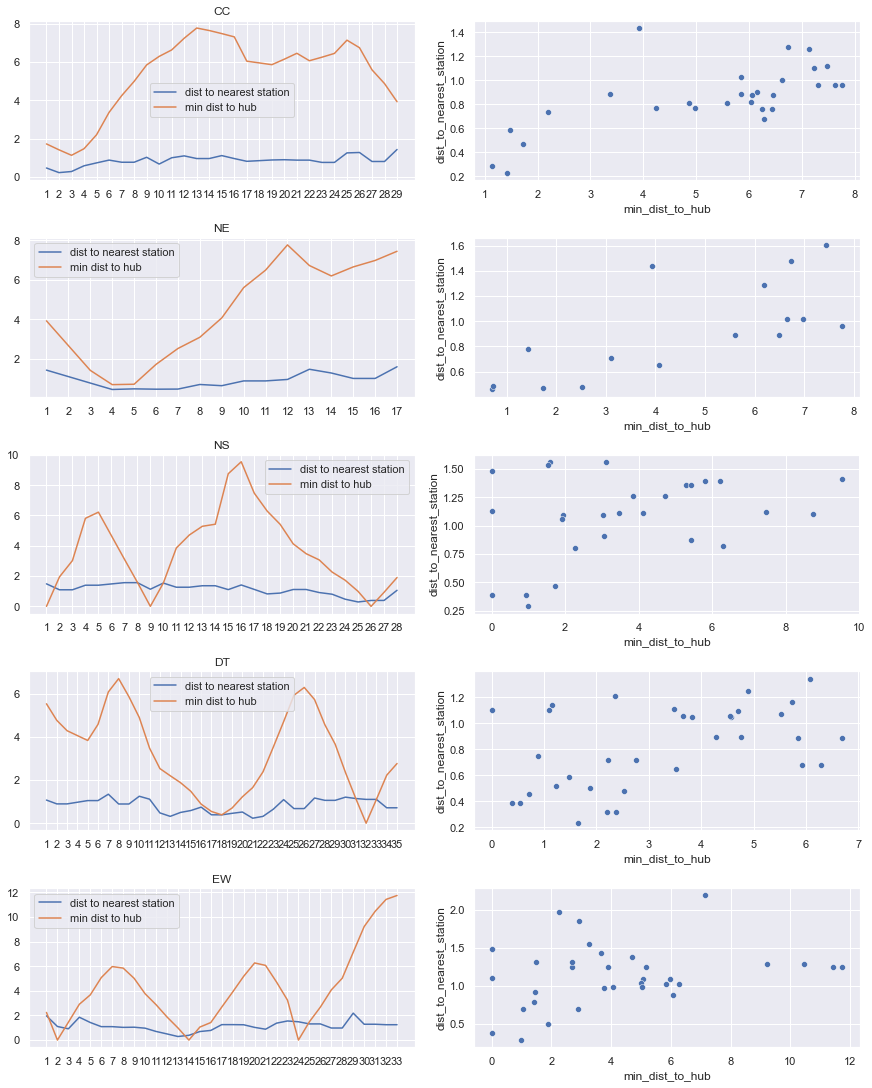

In [112]:
f, axes = plt.subplots(5, 2, figsize=(12, 15), constrained_layout=True)
for i in range(5):
    line = lines[i]
    axes[i,0].plot(line_df[line][line], line_df[line].dist_to_nearest_station, label='dist to nearest station')
    axes[i,0].plot(line_df[line][line], line_df[line].min_dist_to_hub, label='min dist to hub')
    axes[i,0].legend()
    axes[i,0].set_xticks(np.arange(min(line_df[line][line]), max(line_df[line][line])+1))
    axes[i,0].set_title(f'{line}')
    sns.scatterplot(x='min_dist_to_hub', y='dist_to_nearest_station', data=line_df[line], ax=axes[i,1])

plt.show()

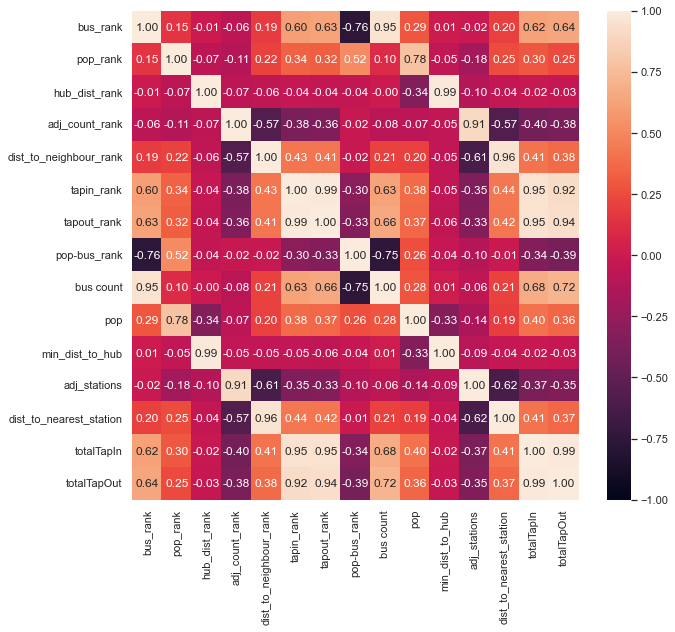

In [130]:
f = plt.figure(figsize=(10,9))
sns.heatmap(op[op.cluster==0][plt_target_cols].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

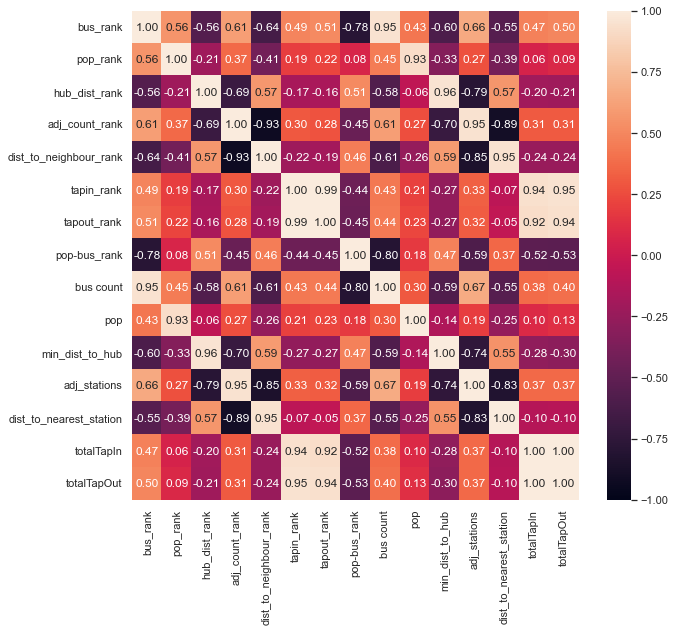

In [131]:
f = plt.figure(figsize=(10,9))
sns.heatmap(op[op.cluster==1][plt_target_cols].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

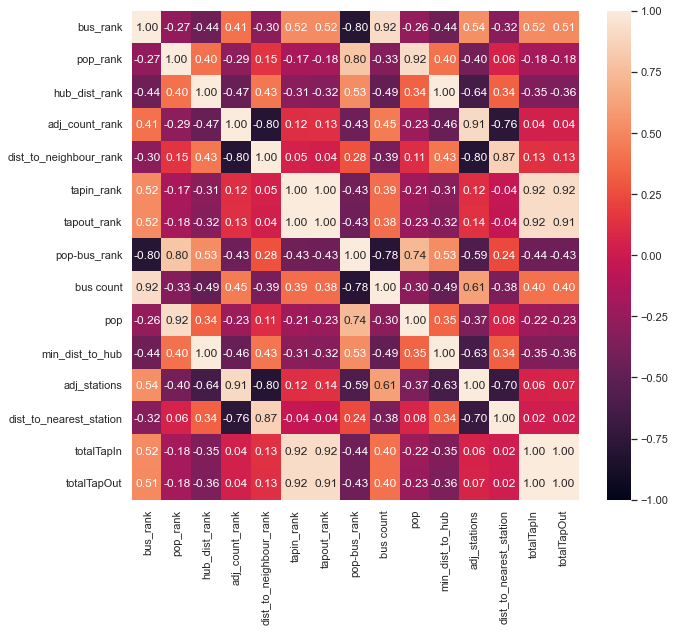

In [132]:
f = plt.figure(figsize=(10,9))
sns.heatmap(op[op.cluster==2][plt_target_cols].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")